# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from ddpg_agent import Agent
from collections import deque
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#env = UnityEnvironment(file_name='Reacher.app')
#env = UnityEnvironment(file_name='C:/Users/hchan/Downloads/Reacher_Windows_x86_64_v1/Reacher.exe')
env = UnityEnvironment(file_name='C:/Users/hchan/Downloads/Reacher_Windows_x86_64_v2/Reacher.exe', no_graphics=True)    

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Parameter setup

The following is where I setup or tune my hyperparameters

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

### 4. Implementation of training and testing section

The follow is my implementation of training and testing codes

In [8]:
def ddpg(agent, train=True):
    
    n_episodes = 1500 if train else 10
    
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        
        while True:
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished
            
            if train:
                agent.step(states, actions, rewards, next_states, dones)
                
            states = next_states
            score += rewards
            if np.any(dones):
                break
                
        if train:
            agent.save_progress()
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(score)), end="")
        if not train or i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=31.0 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            agent.save_progress()
            break        
    return scores

### 5. Training with plot output

The following cell is the training code along with the plot of score vs episodes.

Episode 50	Average Score: 11.25	Score: 36.23
Episode 100	Average Score: 23.66	Score: 31.44
Episode 122	Average Score: 31.03	Score: 35.30
Environment solved in 22 episodes!	Average Score: 31.03


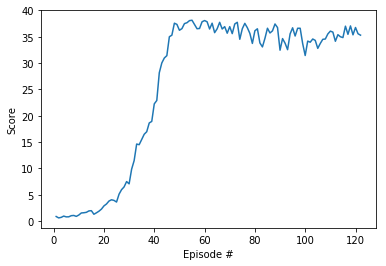

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=4,
             buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, device=DEVICE)
scores = ddpg(agent)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Test DDPG output

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=4,
             buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY, device=DEVICE, load_progress=True)
scores = ddpg(agent, train=False)

Episode 1	Average Score: 37.58	Score: 37.58
Episode 2	Average Score: 36.32	Score: 35.06
Episode 3	Average Score: 36.49	Score: 36.83
Episode 4	Average Score: 36.15	Score: 35.12
Episode 5	Average Score: 36.33	Score: 37.08
Episode 6	Average Score: 36.37	Score: 36.56
Episode 7	Average Score: 36.59	Score: 37.87
Episode 8	Average Score: 36.65	Score: 37.08
Episode 9	Average Score: 36.57	Score: 35.91
Episode 10	Average Score: 36.57	Score: 36.64


In [10]:
env.close()